# 1. Importing Libraries:

In [ ]:
#Basic Libraries
import pandas as pd
import numpy as np
# !pip install featuretools
import featuretools as ft

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing & Feature Engineering
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#ML Model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve

# For tuning and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# 2. Loading Data:

In [ ]:
# Load full column list without loading full data
all_columns = pd.read_csv('train_transaction.csv', nrows=0).columns.tolist()
# Define which D columns you want to keep
keep_D_cols = ['D1', 'D2', 'D3', 'D5', 'D6', 'D10', 'D11', 'D15']
# Define which V columns to keep (based on your numbers)
V_numbers = [
    1, 3, 4, 6, 8, 11, 13, 14, 17, 20, 22, 23, 26, 27, 30, 36, 37,
    127, 165, 203, 180, 218, 307, 296, 332,
    108, 109, 111, 114, 115, 117, 118, 120, 121, 123, 124, 129,
    130, 131, 136, 138, 139, 142, 143, 150, 147, 155, 160, 162,
    165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 185,
    190, 187, 188, 195, 198, 201,
    205, 206, 207, 208, 209, 210, 216, 220,
    221, 223, 224, 226, 227, 228, 229, 238,
    240, 241, 242, 243, 245, 246, 248, 249, 250, 253, 256, 259, 260,
    263, 264, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276,
    280, 283, 285, 286, 287, 289, 291, 301, 303,
    309, 313, 310, 320, 325, 335, 338
]
keep_V_cols = [f'V{num}' for num in V_numbers]
# Build final list: all non-D/V columns + selected D + selected V
other_cols = [col for col in all_columns if not col.startswith('D') and not col.startswith('V')]
selected_columns = other_cols + keep_D_cols + keep_V_cols
# Load only those selected columns
train_transactionDf = pd.read_csv('train_transaction.csv', usecols=selected_columns)

num_features = train_transactionDf.shape[1]

# Alternatively, you can use len() on the columns
num_features = len(train_transactionDf.columns)
print(num_features)

171


In [ ]:
train_identity = pd.read_csv('train_identity.csv')
train_df = train_transactionDf.merge(train_identity, on='TransactionID', how='left')

num_features = len(train_df.columns)
print(num_features)

numerical_df = train_df.select_dtypes(include=['number'])
num_columns = numerical_df.columns
chunk_size = 10
# Loop through and display columns in chunks
for i in range(0, len(num_columns), chunk_size):
    chunk = num_columns[i:i+chunk_size]
    print(f"🔹 Chunk {i//chunk_size + 1}: {list(chunk)}\n")

211
🔹 Chunk 1: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

🔹 Chunk 2: ['dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

🔹 Chunk 3: ['C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D5']

🔹 Chunk 4: ['D6', 'D10', 'D11', 'D15', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11']

🔹 Chunk 5: ['V13', 'V14', 'V17', 'V20', 'V22', 'V23', 'V26', 'V27', 'V30', 'V36']

🔹 Chunk 6: ['V37', 'V108', 'V109', 'V111', 'V114', 'V115', 'V117', 'V118', 'V120', 'V121']

🔹 Chunk 7: ['V123', 'V124', 'V127', 'V129', 'V130', 'V131', 'V136', 'V138', 'V139', 'V142']

🔹 Chunk 8: ['V143', 'V147', 'V150', 'V155', 'V160', 'V162', 'V165', 'V167', 'V168', 'V169']

🔹 Chunk 9: ['V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V185', 'V187']

🔹 Chunk 10: ['V188', 'V190', 'V195', 'V198', 'V201', 'V203', 'V205', 'V206', 'V207', 'V208']

🔹 Chunk 11: ['V209', 'V210', 'V216', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226',

# 3. Encoding Data:

In [ ]:
# Identify numeric & categorical columns
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

# Convert all numeric features to float (XGBoost prefers float)
train_df[numeric_cols] = train_df[numeric_cols].astype("float")

# Function to encode categorical features
def encode_LE(col, df):
    """Label Encodes a categorical column and optimizes memory usage."""
    df_comb, _ = df[col].factorize(sort=True)  # Factorize sorts values before encoding
    if df_comb.max() > 32000:
        df[col] = df_comb.astype("int32")
    else:
        df[col] = df_comb.astype("int16")
    del df_comb
    gc.collect()  # Free up memory

# Encode categorical features with few unique values using Label Encoding
label_enc_cols = [col for col in categorical_cols if train_df[col].nunique() < 20]  # Threshold: 20 unique values

for col in label_enc_cols:
    train_df[col] = train_df[col].fillna("Missing")  # Handle missing values
    encode_LE(col, train_df)

# Encode high-cardinality categorical features using Target Encoding
target_enc_cols = [col for col in categorical_cols if col not in label_enc_cols]

for col in target_enc_cols:
    fraud_mean = train_df.groupby(col)["isFraud"].mean()  # Mean target encoding
    train_df[col] = train_df[col].map(fraud_mean)  # Replace categories with mean fraud probability
    train_df[col].fillna(train_df["isFraud"].mean(), inplace=True)  # Fill missing values

# Verify conversion
print(train_df.dtypes)


TransactionID     float64
isFraud           float64
TransactionDT     float64
TransactionAmt    float64
ProductCD           int16
                   ...   
id_36               int16
id_37               int16
id_38               int16
DeviceType          int16
DeviceInfo        float64
Length: 211, dtype: object


# 4. **Feature Engineering**:


To enhance our dataset and give the model more behavioral context, we decided to add new features using Featuretools, a library for automated feature engineering. The goal was to extract user-level patterns from transaction-level data — something raw features alone couldn’t capture.

We used card1 as a proxy for user identity and created a user_id, assuming it reflects consistent user behavior across transactions. We then grouped transactions by user_id, allowing us to analyze behavior at the user level instead of at the individual transaction level. This grouping was essential — fraud often becomes detectable only when we compare a transaction against the user’s typical behavior.

We split the data into two entities: users (parent) and transactions (child), with each transaction linked to its corresponding user_id. Then we run, Deep Feature Synthesis (DFS) which is the core algorithm in Featuretools that automates feature generation by traversing relationships between tables (e.g., from transactions to users) and applying aggregation functions—called "primitives"—to create meaningful features. For instance, it can compute a user's average transaction amount (mean(TransactionAmt)), total number of transactions (count(TransactionID)), or the variability in a user's behavior (std(D1)). By setting max_depth=1, DFS limits the feature creation to a single level of aggregation from the child (transactions) to the parent (users), without chaining multiple levels of derived features. Using this structure, we applied aggregation functions like mean, mode, count, and standard deviation to generate features that summarize each user’s activity over time.

The intention was to provide the model with richer behavioral insights. However, despite this effort, the model still struggled on fraud cases, yielding very low precision and F1-scores.










In [ ]:
#1. Create user_id from card1
train_df["user_id"] = train_df["card1"].astype(str)

#2. Split into users and transactions
users_df = train_df[["user_id"]].drop_duplicates().reset_index(drop=True)
transactions_df = train_df[["TransactionID", "TransactionDT", "user_id", "TransactionAmt", "addr1", "C1", "D1"]].copy()
transactions_df = transactions_df.fillna(-1.0)

#3. Create EntitySet
es = ft.EntitySet(id="fraud_data")

es = es.add_dataframe(
    dataframe_name="users",
    dataframe=users_df,
    index="user_id"
)

es = es.add_dataframe(
    dataframe_name="transactions",
    dataframe=transactions_df,
    index="TransactionID",
    time_index="TransactionDT"
)

es = es.add_relationship(
    parent_dataframe_name="users",
    parent_column_name="user_id",
    child_dataframe_name="transactions",
    child_column_name="user_id"
)

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="users",
    agg_primitives=["mean", "mode", "count", "std"],
    trans_primitives=[],
    max_depth=1,
    verbose=True
)

print(f"Created {len(feature_matrix.columns)} features")
feature_matrix.head()



NameError: name 'train_df' is not defined

We then experimented with several different parent features to define groupings for feature generation, including card1, addr1, C1, and TransactionDT. However, all these individual features produced similar results, with no significant improvement in model performance. We then tried constructing composite keys using combinations of features — such as card1 + TransactionDT, card1 + C1, and other variations — in hopes of better isolating user-like behavior. Unfortunately, these combinations also failed to yield meaningful gains in predictive power.

As a final attempt, we used a more analytical approach to determine which features would best define user identity and behavior. After evaluating feature importance and behavior consistency across the dataset, we decided to use a composite of card1 and addr1, creating a new feature called card1_addr1. This was used as a group identifier (group_id) under the assumption that the combination would more accurately represent a single user’s behavior profile across transactions.

Using Featuretools, we defined an entity set where group_id represented the parent entity (groups of users), and individual transactions were the child entity. We selected a diverse set of transactional and behavioral features, covering payment metadata, email domains, distances, and categorical flags. Aggregating these using the mean primitive, we generated new group-level features intended to capture summarized behavioral patterns within each composite group.

This grouping strategy led to a slight increase in precision, meaning the model became a bit more conservative and avoided more false positives. However, the improvement was minor, and recall actually dropped slightly, indicating the model caught fewer fraudulent cases. In the end, while this grouping method was more informed than previous ones, the challenge of detecting rare, nuanced fraud behaviors remained largely unsolved through feature engineering alone.

In [ ]:

#1. Create day & uid features inside train_df
train_df["day"] = train_df["TransactionDT"] / (24 * 60 * 60)
train_df["card1_addr1"] = train_df["card1"].astype(str) + "_" + train_df["addr1"].astype(str)

train_df["group_id"] = train_df["card1_addr1"]

#2. Split into parent groups and transactions
group_df = train_df[["group_id"]].drop_duplicates().reset_index(drop=True)

transactions_df = train_df[[
    'TransactionID', 'group_id', 'TransactionDT', 'TransactionAmt', 'addr1',
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6','M7', 'M8', 'M9',
    'dist1', 'dist2',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D2', 'D3', 'D5', 'D6', 'D10', 'D11', 'D15'
]].copy()

transactions_df = transactions_df.fillna(-1.0)

#3. Create EntitySet
es = ft.EntitySet(id="fraud_data")

# Add group (parent)
es = es.add_dataframe(
    dataframe_name="groups",
    dataframe=group_df,
    index="group_id"
)

#Add transactions (child)
es = es.add_dataframe(
    dataframe_name="transactions",
    dataframe=transactions_df,
    index="TransactionID",
    time_index="TransactionDT"
)

#Define the relationship between group and transactions
es = es.add_relationship(
    parent_dataframe_name="groups",
    parent_column_name="group_id",
    child_dataframe_name="transactions",
    child_column_name="group_id"
)

#4. Run DFS to generate group-level features
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="groups",
    agg_primitives=["mean"],
    trans_primitives=[],
    max_depth=1,
    verbose=True
)

print(feature_defs)
print(f"Created {len(feature_matrix.columns)} features")
feature_matrix.head()


In [ ]:
feature_matrix = feature_matrix.reset_index()
# Merge back with the transaction-level data using 'group_id'
train_merged = train_df.merge(feature_matrix, on="group_id", how="left")

print(f"✅ Merged shape: {train_merged.shape}")
train_merged.head()

#

✅ Merged shape: (590540, 256)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,MEAN(transactions.P_emaildomain),MEAN(transactions.ProductCD),MEAN(transactions.R_emaildomain),MEAN(transactions.TransactionAmt),MEAN(transactions.TransactionDT),MEAN(transactions.addr1),MEAN(transactions.card4),MEAN(transactions.card6),MEAN(transactions.dist1),MEAN(transactions.dist2)
0,2987000.0,0.0,86400.0,68.5,4,13926.0,NaN,150.0,2,142.0,...,0.036573,3.000000,0.034990,142.000000,2.582964e+06,315.0,2.000000,2.000000,5.666667,-1.000000
1,2987001.0,0.0,86401.0,29.0,4,2755.0,404.0,150.0,3,102.0,...,0.032862,3.819672,0.035683,275.521639,6.451158e+06,325.0,2.950820,1.967213,245.737705,162.213115
2,2987002.0,0.0,86469.0,59.0,4,4663.0,490.0,150.0,4,166.0,...,0.044719,3.911765,0.036249,52.433529,7.251093e+06,330.0,4.000000,3.000000,41.176471,-1.000000
3,2987003.0,0.0,86499.0,50.0,4,18132.0,567.0,150.0,3,117.0,...,0.030769,3.929961,0.036143,124.769533,5.574452e+06,476.0,2.988327,2.988327,122.198444,-1.000000
4,2987004.0,0.0,86506.0,50.0,1,4497.0,514.0,150.0,3,102.0,...,0.043542,1.000000,0.034990,50.000000,8.650600e+04,420.0,3.000000,2.000000,-1.000000,-1.000000


In [ ]:
# Features: exclude obvious IDs, time, and isFraud target
drop_cols = ["TransactionID", "TransactionDT", "user_id","group_id" ,"isFraud","card1_addr1"]
X = train_df.drop(columns=drop_cols, errors='ignore')
y = train_df["isFraud"]

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": scale_pos_weight,
    "seed": 42
}

evals = [(dtrain, "train"), (dval, "eval")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_probs = model.predict(dval)
y_pred = (y_probs >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_probs))


[0]	train-auc:0.87714	eval-auc:0.86695
[1]	train-auc:0.89046	eval-auc:0.88198
[2]	train-auc:0.89664	eval-auc:0.88639
[3]	train-auc:0.89920	eval-auc:0.88902
[4]	train-auc:0.90289	eval-auc:0.89241
[5]	train-auc:0.90511	eval-auc:0.89495
[6]	train-auc:0.90676	eval-auc:0.89655
[7]	train-auc:0.90752	eval-auc:0.89702
[8]	train-auc:0.90869	eval-auc:0.89801
[9]	train-auc:0.90969	eval-auc:0.89911
[10]	train-auc:0.91041	eval-auc:0.89962
[11]	train-auc:0.91141	eval-auc:0.90033
[12]	train-auc:0.91196	eval-auc:0.90060
[13]	train-auc:0.91282	eval-auc:0.90140
[14]	train-auc:0.91344	eval-auc:0.90169
[15]	train-auc:0.91418	eval-auc:0.90261
[16]	train-auc:0.91505	eval-auc:0.90344
[17]	train-auc:0.91589	eval-auc:0.90439
[18]	train-auc:0.91673	eval-auc:0.90517
[19]	train-auc:0.91759	eval-auc:0.90580
[20]	train-auc:0.91811	eval-auc:0.90624
[21]	train-auc:0.91888	eval-auc:0.90703
[22]	train-auc:0.91963	eval-auc:0.90780
[23]	train-auc:0.92026	eval-auc:0.90832
[24]	train-auc:0.92115	eval-auc:0.90926
[25]	train

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


🧮 Confusion Matrix:
[[112069   1906]
 [   714   3419]]


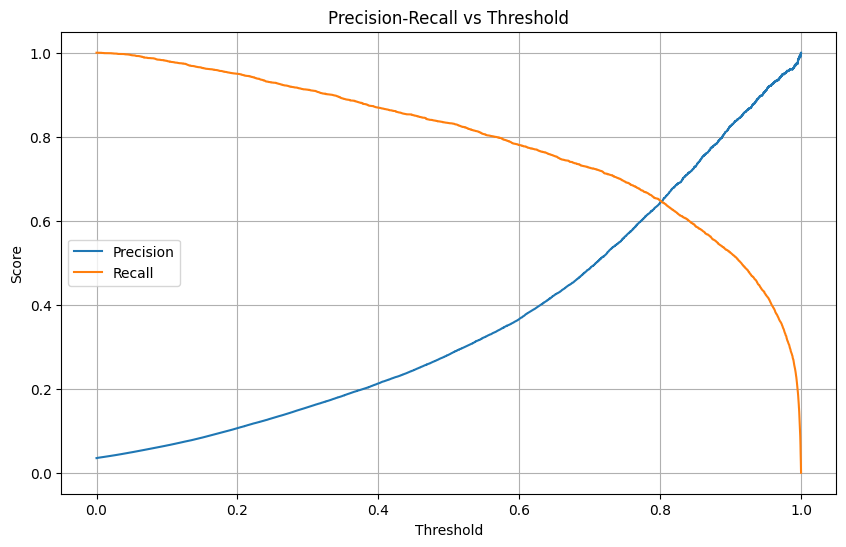

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    113975
         1.0       0.56      0.69      0.62      4133

    accuracy                           0.97    118108
   macro avg       0.78      0.84      0.80    118108
weighted avg       0.97      0.97      0.97    118108

Confusion matrix:
 [[111741   2234]
 [  1268   2865]]


In [ ]:
# print(train_df["isFraud"].value_counts())
# xgb.plot_importance(model, max_num_features=15)
# plt.title("Top 15 Feature Importances")
# plt.show()
# Get probabilities of class 1 (fraud)
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Choose the new threshold
custom_threshold = 0.75

# Apply it to probabilities
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_custom))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))

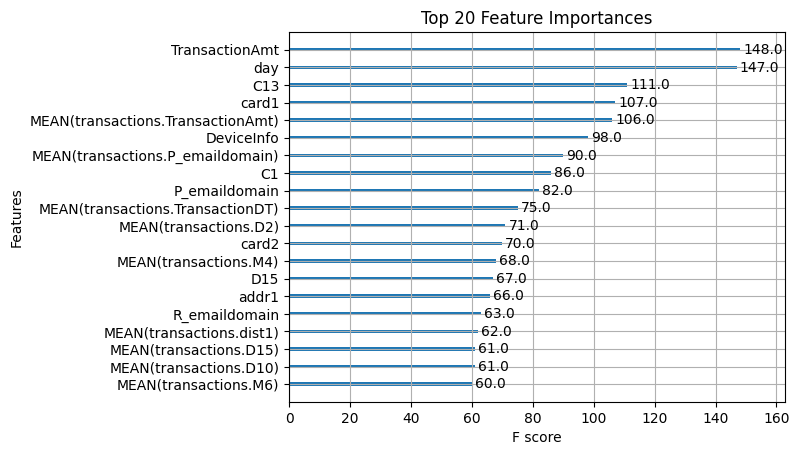

In [ ]:
from xgboost import plot_importance

plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()